# Pipeline:

In [1]:
!pip install rdkit-pypi==2022.9.1

In [2]:
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch_geometric

from torch.nn import Linear
from torch.nn import functional as F 
from torch.optim.lr_scheduler import ExponentialLR

from torch_geometric.utils.smiles import from_smiles
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.nn.norm import BatchNorm


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <B5FD9895-F13C-386E-85C3-E2998159857E> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


## Read the data:

In [4]:
url_file_path = "https://raw.githubusercontent.com/volkamerlab/teachopencadd/master/teachopencadd/talktorials/T002_compound_adme/data/EGFR_compounds_lipinski.csv"
df = pd.read_csv(url_file_path)

# Display the first few rows of the DataFrame
df.head()


,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
2,2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
3,3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True
4,4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True


In [5]:
len(df)

4635

# Plot a histogram of the distribution:

In [6]:
names_data = df["molecule_chembl_id"].tolist()
smile_data = df["smiles"].tolist()
pIC50_data = df["pIC50"].tolist()
assert len(names_data) == len(smile_data) == len(pIC50_data)

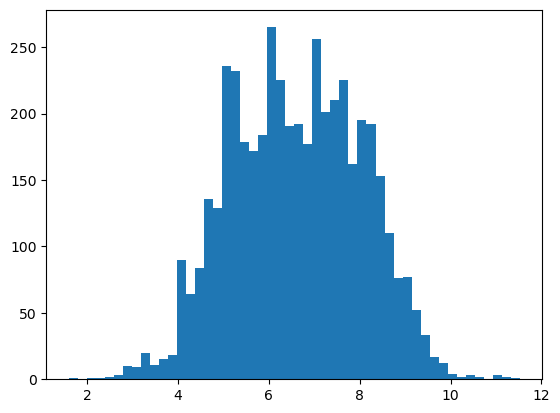

In [7]:
plt.hist(pIC50_data, bins=50)
plt.title("")
plt.show()

## Split the dataset:

In [8]:
def shuffle_lists_together(list1, list2, list3):
    # Combine the input lists using zip
    combined_lists = list(zip(list1, list2, list3))

    # Shuffle the combined list
    random.shuffle(combined_lists)

    # Unpack the shuffled values back into separate lists
    shuffled_list1, shuffled_list2, shuffled_list3 = zip(*combined_lists)

    # Convert the tuples back to lists
    shuffled_list1 = list(shuffled_list1)
    shuffled_list2 = list(shuffled_list2)
    shuffled_list3 = list(shuffled_list3)

    return shuffled_list1, shuffled_list2, shuffled_list3


In [9]:
random.seed(23)  # shuffle with random seed for reproducibility
names_data, smile_data, pIC50_data = shuffle_lists_together(names_data, smile_data, pIC50_data)

## Split the datasets:

In [10]:
train_valid_infer_split = [0.8, 0.1, 0.1]

train_splitter = 0, round(train_valid_infer_split[0] * len(names_data))
valid_splitter = train_splitter[1], round((train_valid_infer_split[0] + train_valid_infer_split[1]) * len(names_data))
infer_splitter = valid_splitter[1], len(names_data)
train_splitter, valid_splitter, infer_splitter


((0, 3708), (3708, 4172), (4172, 4635))

In [11]:
train_names_data = names_data[train_splitter[0]:train_splitter[1]]
train_smile_data = smile_data[train_splitter[0]:train_splitter[1]]
train_pIC50_data = pIC50_data[train_splitter[0]:train_splitter[1]]

valid_names_data = names_data[valid_splitter[0]:valid_splitter[1]]
valid_smile_data = smile_data[valid_splitter[0]:valid_splitter[1]]
valid_pIC50_data = pIC50_data[valid_splitter[0]:valid_splitter[1]]

infer_names_data = names_data[infer_splitter[0]:infer_splitter[1]]
infer_smile_data = smile_data[infer_splitter[0]:infer_splitter[1]]
infer_pIC50_data = pIC50_data[infer_splitter[0]:infer_splitter[1]]

len(train_names_data), len(valid_names_data), len(infer_names_data)

(3708, 464, 463)

### Visualise:

In [12]:
def prepare_cdf(values: list[float], bins: int = 50) -> tuple[list[float], list[float]]:
    """Helper function to plot the CDF plots."""
    count, bins_count = np.histogram(values, bins=bins)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return bins_count[1:], cdf
    

In [13]:
def plot_distributions(pIC50_values: list[list[float]]) -> None:
    """Plot the histogram & CDF of train, (valid) and test set logD values."""
    
    names = ["Train", "Valid", "Test"]
    # Plot the histogram
    for i in range(len(pIC50_values)):
        plt.hist(pIC50_values[i], label=f"{names[i]} Data")
    
    plt.title("Dataset pIC50 value distribution")
    plt.xlabel("pIC50 Value")
    plt.ylabel("Compounds")
    plt.legend()
    plt.show()

    # Plot the CDF
    for i in range(len(pIC50_values)):
        bc, cdf = prepare_cdf(values=pIC50_values[i])
        plt.plot(bc, cdf, label=f"{names[i]} Data")

    plt.title("Dataset pIC50 value CDF curve")
    plt.ylabel("Cumulative Density")
    plt.xlabel("pIC50 Value")
    plt.legend()
    plt.show()


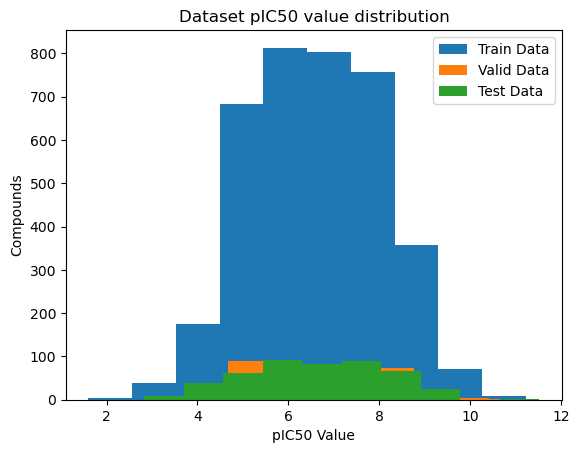

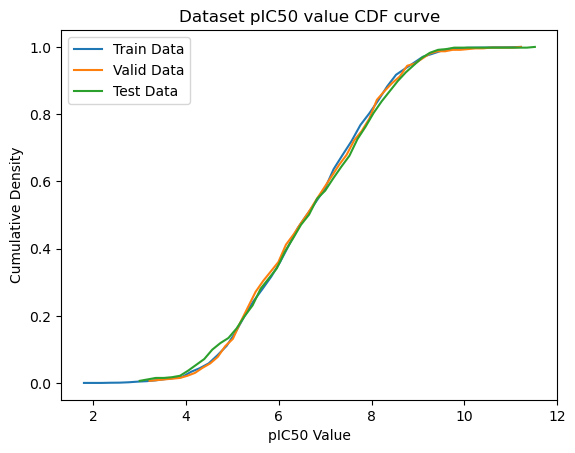

In [14]:
plot_distributions([train_pIC50_data, valid_pIC50_data, infer_pIC50_data])

### Normalise (and later de-normalise) the y-label value:

In [15]:
y_min, y_max = np.min(train_pIC50_data), np.max(train_pIC50_data)
y_min, y_max

(1.6020599913279625, 11.221848749616356)

In [16]:
def normalise_pIC50_value(
    y: float | torch.Tensor, 
    y_min: float | torch.Tensor, 
    y_max: float | torch.Tensor,
) -> float | torch.Tensor:
    return ( y - y_min ) / ( y_max - y_min )


In [17]:
def denormalise_pIC50_value(
    y_norm: float | torch.Tensor, 
    y_min: float | torch.Tensor,
    y_max: float | torch.Tensor,
) -> float | torch.Tensor:
    return y_norm * ( y_max - y_min ) + y_min
    

## Create pytorch geometric dataset:

In [18]:
def prepare_graph_dataset(
    smile_list: list[str], 
    pIC50_list: list[float], 
    names_list: list[str],
    problem: str = "classification",
) -> list[torch_geometric.data]:
    """Create the 'dataset' by converting the SMILES strings to featurised 
        graphs via deepchem package, and attaching the 'y' labels to 
        the 'x' features (both as float tensors)."""
    assert len(smile_list) == len(pIC50_list) == len(names_list)

    # Featurise the graph data:
    data_list = []
    
    for i in tqdm(range(len(smile_list))):
        smiles = smile_list[i]
        graph_dataset = from_smiles(smiles)
        graph_dataset.ID = names_list[i]
        graph_dataset.x = graph_dataset.x.to(torch.float32)
            
        if problem == "regression":
            graph_dataset.y = torch.Tensor([pIC50_list[i]])

        elif problem == "classification":
            class_label = torch.Tensor([pIC50_list[i] > 8.0])
            graph_dataset.y = class_label.long()

        else:
            raise NotImplementedError("Choose an implemented approach.")

        data_list.append(graph_dataset)
    
    return data_list


In [19]:
PROBLEM = "classification"
PROBLEM

'classification'

In [20]:
train_dataset = prepare_graph_dataset(
    smile_list=train_smile_data, 
    pIC50_list=train_pIC50_data, 
    names_list=train_names_data, 
    problem=PROBLEM,
)

valid_dataset = prepare_graph_dataset(
    smile_list=valid_smile_data, 
    pIC50_list=valid_pIC50_data, 
    names_list=valid_names_data, 
    problem=PROBLEM,
)

infer_dataset = prepare_graph_dataset(
    smile_list=infer_smile_data, 
    pIC50_list=infer_pIC50_data, 
    names_list=infer_names_data, 
    problem=PROBLEM,
)

len(train_dataset), len(valid_dataset), len(infer_dataset)

100%|██████████| 463/463 [00:01<00:00, 276.68it/s]


(3708, 464, 463)

In [21]:
train_dataset[0]

Data(x=[28, 9], edge_index=[2, 62], edge_attr=[62, 3], smiles='Cc1ccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3n2)cc1', ID='CHEMBL111339', y=[1])

In [22]:
train_dataset[0].x.dtype, train_dataset[0].y.dtype

(torch.float32, torch.int64)

### Ensure label distributions are i.i.d.:

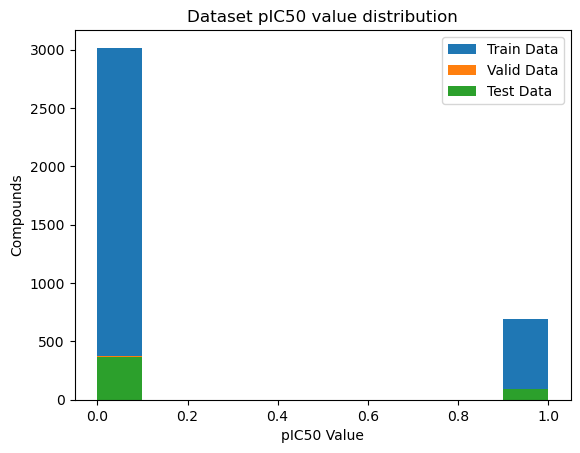

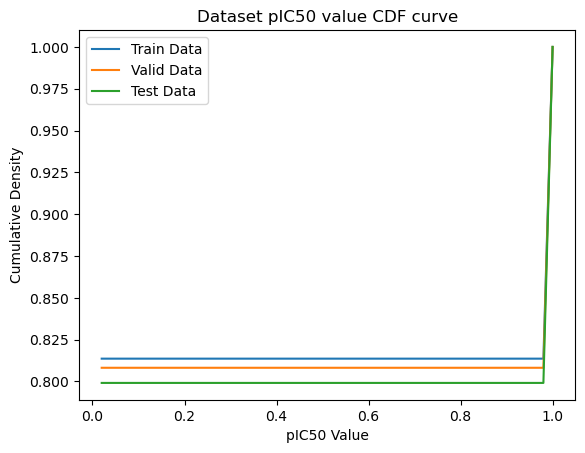

In [23]:
plot_distributions([
    [g.y.item() for g in train_dataset], 
    [g.y.item() for g in valid_dataset], 
    [g.y.item() for g in infer_dataset], 
])

### Wrap into the DataLoader:

In [30]:
config = {
    "batch_size" : 64,
    "dropout_prob" : 0.2,
    "num_features" : train_dataset[0].num_features, 
    "num_attn_heads" : 8,
    "embedding_size" : 64, 
    "use_batch_norm" : False,
    "learning_rate" : 1e-3,
    "weight_decay" : 1e-5,
    "scheduler_gamma" : 0.99,
    "num_epochs" : 200,
    "pos_class_weight" : 2.5,
    "problem_type" : 'classification',
    "logging_frequency" : 20,
}



In [26]:
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config["batch_size"], shuffle=False)
infer_loader = DataLoader(infer_dataset, batch_size=config["batch_size"], shuffle=False)


## Build the GNN model:

In [27]:
class GAT(torch.nn.Module):
    """Graph Attention Network"""

    def __init__(self, num_features: int, embedding_size: int, num_attn_heads: int, dropout_prob: float, use_batch_norm: bool = False) -> None:
        # Init parent
        super(GAT, self).__init__()
        self.dropout_prob = dropout_prob
        
        # 3-layered GAT
        self.gat1 = GATv2Conv(num_features, embedding_size, heads=num_attn_heads)
        self.gat2 = GATv2Conv(embedding_size*num_attn_heads, embedding_size, heads=num_attn_heads//2)
        self.gat3 = GATv2Conv(embedding_size*num_attn_heads//2, embedding_size, heads=1)

        # 3-layered batch norm
        self.use_batch_norm = use_batch_norm
        if self.use_batch_norm:
            self.gat1_bn = BatchNorm(embedding_size*num_attn_heads)
            self.gat2_bn = BatchNorm(embedding_size*num_attn_heads//2)
            self.gat3_bn = BatchNorm(embedding_size)
            
        # Output layer
        self.out = Linear(embedding_size*2, 2)
        

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, batch_index: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Conv layers
        hidden = F.dropout(x, p=self.dropout_prob, training=self.training)
        hidden = self.gat1(hidden, edge_index)
        if self.use_batch_norm:
            hidden = self.gat1_bn(hidden)
        hidden = F.leaky_relu(hidden)
        
        hidden = F.dropout(hidden, p=self.dropout_prob, training=self.training)
        hidden = self.gat2(hidden, edge_index)
        if self.use_batch_norm:
            hidden = self.gat2_bn(hidden)
        hidden = F.leaky_relu(hidden)
          
        hidden = F.dropout(hidden, p=self.dropout_prob, training=self.training)
        hidden = self.gat3(hidden, edge_index)
        if self.use_batch_norm:
            hidden = self.gat3_bn(hidden)
        hidden = F.leaky_relu(hidden)
        
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([global_max_pool(hidden, batch_index), 
                            global_mean_pool(hidden, batch_index)], dim=1)
        
        # Apply a final linear for regression
        out = self.out(hidden)
        
        return out, hidden


In [28]:
def build_model(
    num_features: int, 
    embedding_size: int, 
    num_heads: int, 
    dropout_prob: float, 
    learning_rate: float,
    weight_decay: float,
    scheduler_gamma: float,
) -> tuple[
    torch.nn.Module, 
    torch.optim.Adam, 
    torch.optim.lr_scheduler.ExponentialLR
]:
    """Build the model object & send it to GPU."""
    
    # Construct the model
    model = GAT(num_features, embedding_size, num_heads, dropout_prob)
    print (model)
    print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

    # Define the optimizer:
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay, 
    )

    scheduler = ExponentialLR(
        optimizer, 
        gamma=scheduler_gamma,
    )
      
    return model, optimizer, scheduler


### Define loss criterion:

In [32]:
# loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()

# weight = None
weight = torch.Tensor([1.0, config["pos_class_weight"]])  # Adjust the value as needed
loss_fn = torch.nn.CrossEntropyLoss(weight=weight)

# pos_weight = torch.tensor([5.0])  # Adjust the value as needed
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
weight, loss_fn

(tensor([1.0000, 2.5000]), CrossEntropyLoss())

In [33]:
def rmse_metric(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Calculate the RMSE metric of interest between true & predicted value."""
    y_t = denormalise_pIC50_value(y_true, y_min, y_max)
    y_p = denormalise_pIC50_value(y_pred, y_min, y_max)
    return torch.sqrt(torch.mean((y_p-y_t)**2))


In [34]:
def accuracy_metric(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """Calculate the RMSE metric of interest between true & predicted value."""
    acc = accuracy_score(y_true=y_true, y_pred=y_pred, )
    return torch.Tensor([acc])

In [35]:
def epoch_step(data_loader: torch_geometric.loader.dataloader.DataLoader, 
               model: torch.nn.Module, 
               optimizer: torch.optim.Adam = None, 
               problem_type: str = "classification"
              ) -> tuple[float, float]:

    if optimizer is not None:
        model.train()
    else:
        model.eval()

    losses, metric = [], []
    
    for batch in data_loader:
      
        # Reset gradients
        if optimizer is not None:
            optimizer.zero_grad() 
        
        # Passing the node features and the connection info
        prediction, _ = model(batch.x, batch.edge_index, batch.batch) 
        true = batch.y
        
        # Calculating the loss and update the gradients
        loss = loss_fn(prediction, true)  

        if optimizer is not None:
            loss.backward()  
            optimizer.step()   
        
        # Calculate metric
        if problem_type == "regression":
            m = rmse_metric(prediction, batch.y)
            metric.append(m.item())
            
        if problem_type == "classification":
            arg = prediction.argmax(dim=1)
            m = accuracy_metric(arg, true)
            
        metric.append(m.item())
        losses.append(loss.item())
        
    return np.mean(losses), np.mean(metric)


In [36]:
def train_model(
    model: torch.nn.Module, 
    optimizer = None, 
    scheduler = None,
    train_loader = None, 
    valid_loader = None, 
    infer_loader = None, 
    num_epochs: int = 100, 
    logger_freq: int = 10,
    verbose: bool = True,
) -> tuple[
    torch.nn.Module, 
    list[float], 
    list[float], 
    list[float], 
    list[float], 
    float, 
    float
]:

    if verbose:
        valid = "EXCLUDED" if valid_loader is None else "INCLUDED"
        print(f"Starting training... for {num_epochs} epochs\t Validation = {valid}\n")
    
    train_losses, train_metric, valid_losses, valid_metric = [[] for _ in range(4)]
    
    for epoch in range(num_epochs):

        # Train:
        train_loss, train_met = epoch_step(train_loader, model, optimizer)
        train_losses.append(train_loss)
        train_metric.append(train_met)
        
        # Valid:
        valid_loss, valid_met = epoch_step(valid_loader, model, optimizer=None)
        valid_losses.append(valid_loss)
        valid_metric.append(valid_met)
            
        lr = optimizer.param_groups[-1]['lr']
        scheduler.step()
        
        # Print epoch update:
        logger_freq = num_epochs // 10 if logger_freq is None else logger_freq
        if verbose:
            if epoch % logger_freq == 0:
                print("Epoch {} | Learning rate: {:0.6f} | "
                      "Train Loss {:0.4f} | Train Metric {:0.2f} | "
                      "Valid Loss {:0.4f} | Valid Metric {:0.2f} |"
                      "".format(epoch, lr, train_loss, train_met, valid_loss, valid_met))
                
    if verbose:
        print(f"\nFinished training...")
    
    # Test:
    test_loss, test_met = epoch_step(infer_loader, model, optimizer=None)
    if verbose:
        print(f"\nRunning inference on test data...\t"
           "Test Loss {:0.4f} | Test Metric {:0.4f}\n\n".format(test_loss, test_met))
          
    return model, train_losses, train_metric, valid_losses, valid_metric, test_loss, test_met


## Train the model:

In [37]:
# # Define model architecture hyperparams:

# NUM_FEATURES = train_dataset[0].num_features
# EMBEDDING_SIZE = 64
# NUM_HEADS = 8
# DROPOUT_PROB = 0.2


In [38]:
# # Define the training hyperparams:

# LEARNING_RATE = 1e-3
# WEIGHT_DECAY = 1e-5
# SCHEDULER_GAMMA = 1.00  # 0.99
# NUM_EPOCHS = 200
# LOG_FREQ = 20

In [39]:
# Build the model, optimiser & scheduler:

# gat_model, gat_optimizer, gat_scheduler = build_model(
#     num_features=NUM_FEATURES, 
#     embedding_size=EMBEDDING_SIZE, 
#     num_heads=NUM_HEADS, 
#     dropout_prob=DROPOUT_PROB,
#     learning_rate=LEARNING_RATE,
#     weight_decay=WEIGHT_DECAY,
#     scheduler_gamma=SCHEDULER_GAMMA,
# )

gat_model, gat_optimizer, gat_scheduler = build_model(
    num_features=config["num_features"], 
    embedding_size=config["embedding_size"], 
    num_heads=config["num_attn_heads"], 
    dropout_prob=config["dropout_prob"],
    learning_rate=config["learning_rate"],
    weight_decay=config["weight_decay"],
    scheduler_gamma=config["scheduler_gamma"],
)

GAT(
  (gat1): GATv2Conv(9, 64, heads=8)
  (gat2): GATv2Conv(512, 64, heads=4)
  (gat3): GATv2Conv(256, 64, heads=1)
  (out): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameters:  307714


In [41]:
# Train the model:

results = train_model(
    gat_model, 
    gat_optimizer, 
    gat_scheduler,    
    train_loader = train_loader, 
    valid_loader = valid_loader, 
    infer_loader = infer_loader, 
    # num_epochs = config["num_epochs"], 
    num_epochs = 10, 
    # logger_freq = config["logging_frequency"], 
    logger_freq = 5, 
)


Starting training... for 10 epochs	 Validation = INCLUDED

Epoch 0 | Learning rate: 0.000990 | Train Loss 0.6530 | Train Metric 0.81 | Valid Loss 0.6447 | Valid Metric 0.82 |
Epoch 5 | Learning rate: 0.000941 | Train Loss 0.6429 | Train Metric 0.79 | Valid Loss 0.6217 | Valid Metric 0.81 |

Finished training...

Running inference on test data...	Test Loss 0.6337 | Test Metric 0.7992




## Evaluate performance:

In [42]:
pre_trained_model, train_losses, train_metric, valid_losses, valid_metric, infer_loss, infer_metr = results
pre_trained_model.eval()


GAT(
  (gat1): GATv2Conv(9, 64, heads=8)
  (gat2): GATv2Conv(512, 64, heads=4)
  (gat3): GATv2Conv(256, 64, heads=1)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

In [43]:
def plot_curves(train_losses: list[float], valid_losses: list[float], infer_loss: float) -> None:
    
    num_epochs = len(train_losses)
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Valid")
    plt.plot([0, num_epochs], [infer_loss, infer_loss], label="Infer")
    plt.title(f"Training for {num_epochs}-epoch GAT model")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    

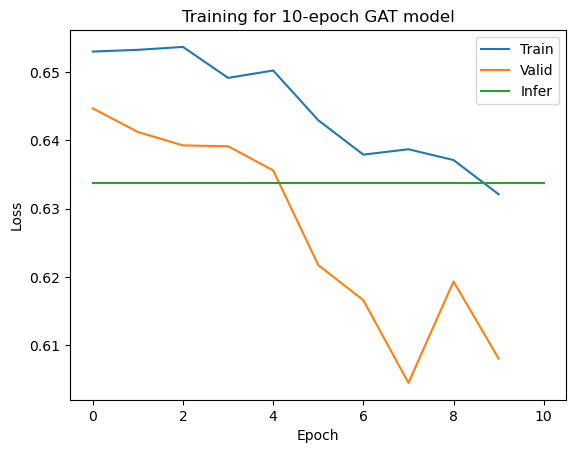

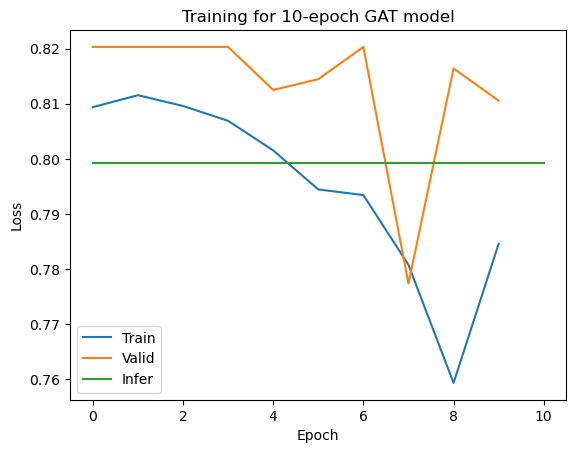

In [44]:
plot_curves(train_losses, valid_losses, infer_loss)
plot_curves(train_metric, valid_metric, infer_metr)


### Evaluate metrics:

In [45]:
def compute_metrics_and_matrix_regression(data_loader):
    y_pred_results = []
    y_true_results = []

    for batch in data_loader:
    
        # Passing the node features and the connection info
        predictions, _ = pre_trained_model(batch.x, batch.edge_index, batch.batch)
        y_pred = predictions.squeeze()
        y_true = batch.y.squeeze()
        
        # Process into integer predictions:
        y_pred = [value > 8.0 for value in y_pred]
        y_true = [value > 8.0 for value in y_true]
        
        # Store the result:
        y_pred_results.extend(y_pred)
        y_true_results.extend(y_true)

    y_pred_results = np.stack(y_pred_results)
    y_true_results = np.stack(y_true_results)

    accuracy = accuracy_score(y_true=y_true_results, y_pred=y_pred_results)
    precision, recall, f1score, support = precision_recall_fscore_support(y_true=y_true_results, y_pred=y_pred_results, pos_label=1)
    metrics = {
        "accuracy" : accuracy, 
        "precision" : precision, 
        "recall" : recall, 
        "f1score" : f1score,
}
    conf_matrix = ConfusionMatrixDisplay.from_predictions(
        y_true=y_true_results, 
        y_pred=y_pred_results,
        normalize="true",
        cmap="copper"
    )
    
    return metrics, conf_matrix


In [46]:
def compute_metrics_and_matrix_classification(data_loader):
    y_pred_results = []
    y_true_results = []

    for batch in data_loader:
    
        # Passing the node features and the connection info
        predictions, _ = pre_trained_model(batch.x, batch.edge_index, batch.batch)
        y_pred = predictions.argmax(dim=1)
        y_true = batch.y.squeeze()
        
        # Store the result:
        y_pred_results.extend(y_pred)
        y_true_results.extend(y_true)

    y_pred_results = np.stack(y_pred_results)
    y_true_results = np.stack(y_true_results)

    accuracy = accuracy_score(y_true=y_true_results, y_pred=y_pred_results)
    precision, recall, f1score, _ = precision_recall_fscore_support(y_true=y_true_results, y_pred=y_pred_results, pos_label=1)
    metrics = {
        "accuracy" : accuracy, 
        "precision" : precision[1], 
        "recall" : recall[1], 
        "f1score" : f1score[1],
}
    conf_matrix = ConfusionMatrixDisplay.from_predictions(
        y_true=y_true_results, 
        y_pred=y_pred_results,
        normalize="true",
    )

    auroc_curve = RocCurveDisplay.from_predictions(
        y_true=y_true_results, 
        y_pred=y_pred_results,
    )

    avg_pred_curve = PrecisionRecallDisplay.from_predictions(
        y_true=y_true_results,
        y_pred=y_pred_results,
    )
    
    return metrics, conf_matrix, auroc_curve, avg_pred_curve


{'accuracy': 0.802049622437972, 'precision': 0.3785310734463277, 'recall': 0.09696092619392185, 'f1score': 0.1543778801843318}


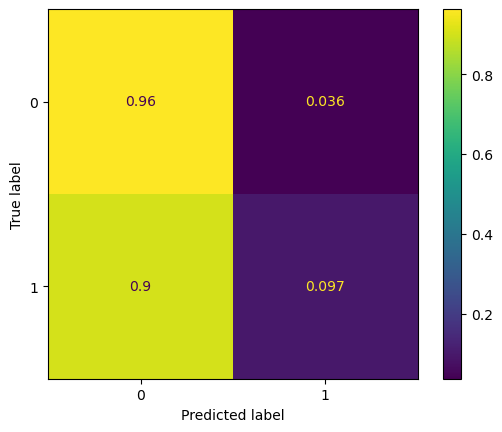

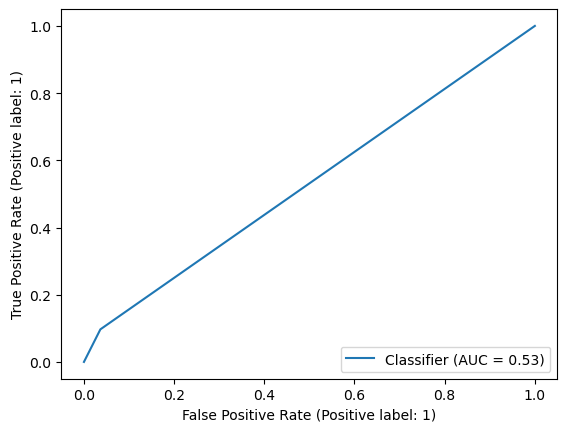

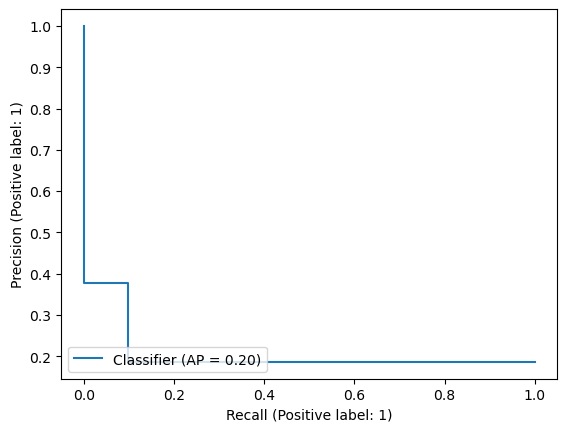

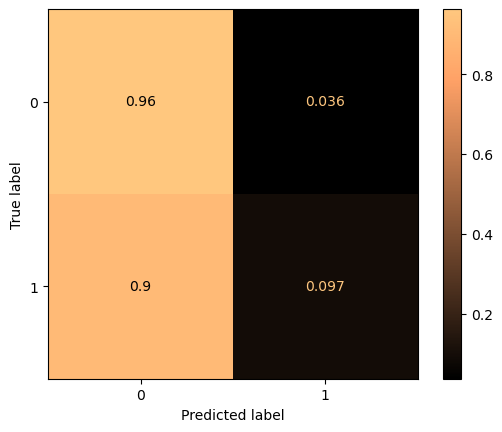

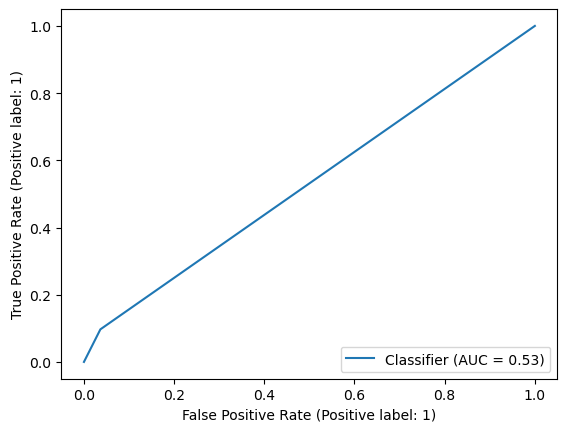

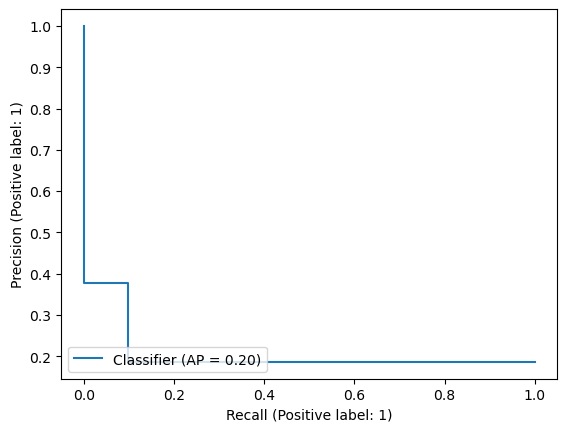

{'accuracy': 0.7974137931034483, 'precision': 0.391304347826087, 'recall': 0.10112359550561797, 'f1score': 0.16071428571428573}


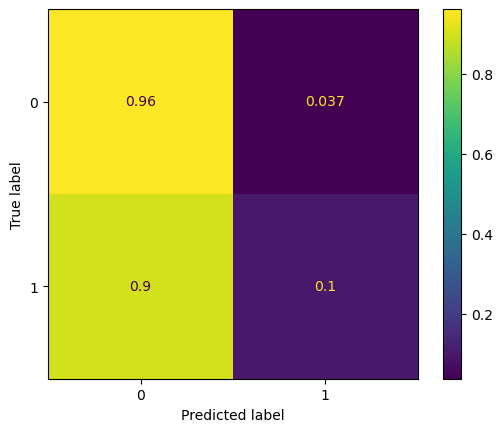

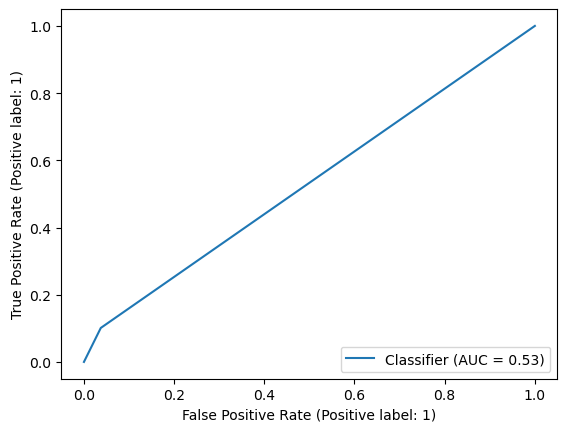

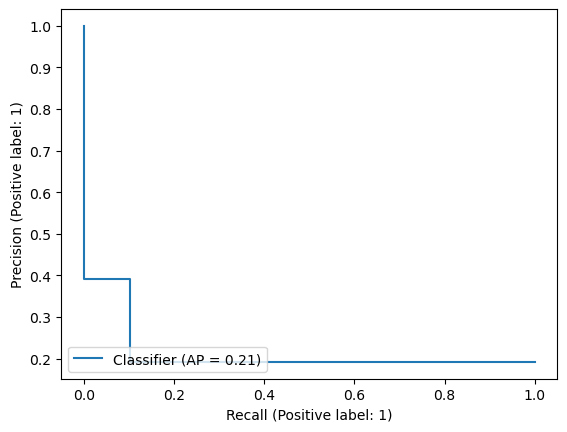

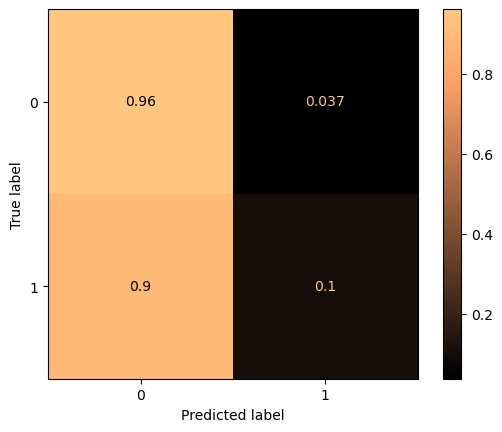

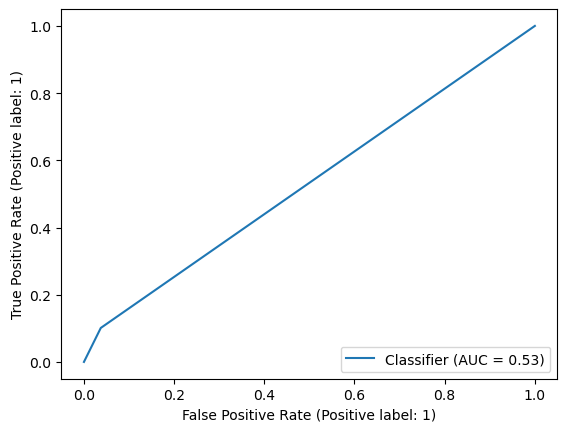

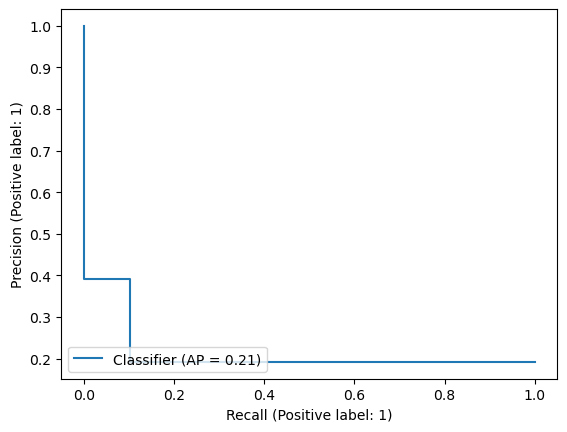

{'accuracy': 0.7991360691144709, 'precision': 0.5, 'recall': 0.11827956989247312, 'f1score': 0.19130434782608696}


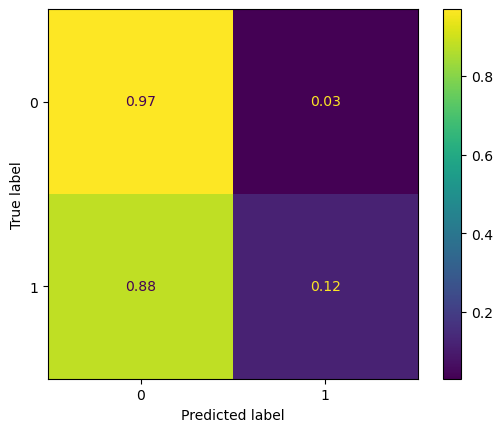

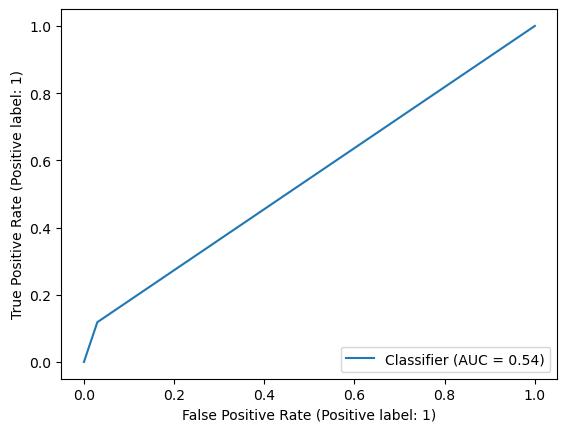

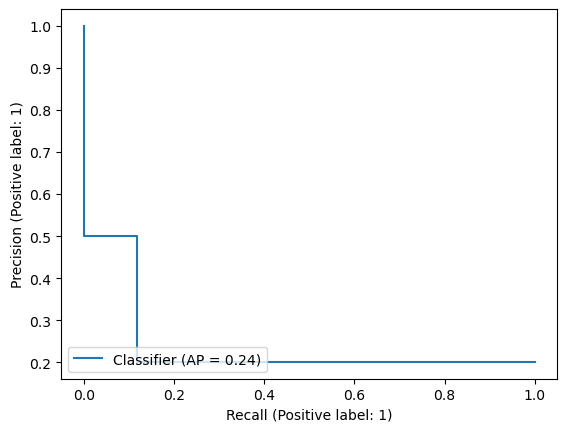

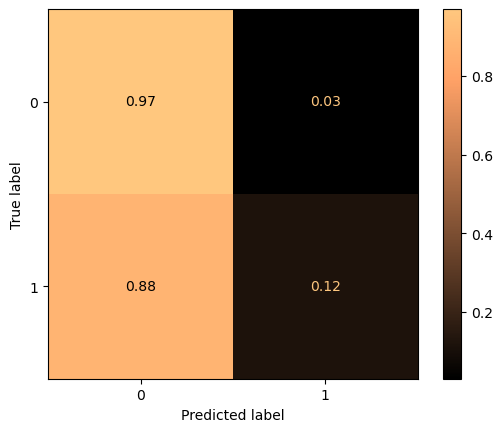

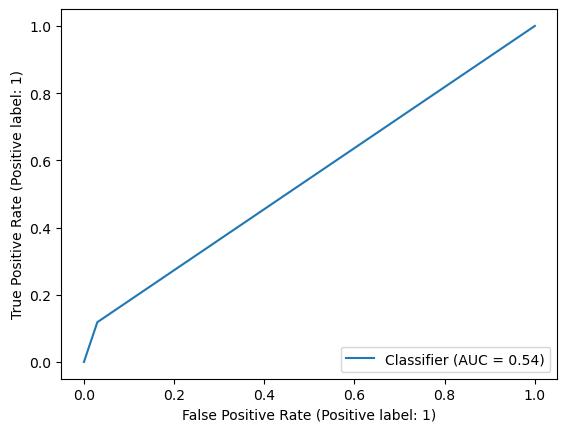

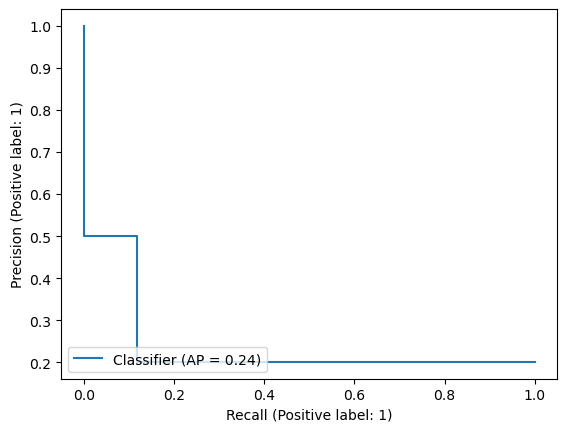

In [47]:
for loader in (train_loader, valid_loader, infer_loader):
    # metrics, conf_matrix = compute_metrics_and_matrix_regression(data_loader=loader)
    metrics, conf_matrix, auroc_curve, avg_pred_curve = compute_metrics_and_matrix_classification(data_loader=loader)
    print (metrics)
    conf_matrix.plot(cmap="copper")
    plt.show()
    auroc_curve.plot()
    plt.show()
    avg_pred_curve.plot()
    plt.show()
    

### Save the model & resulting metrics as appropriate:

In [48]:
torch.save(pre_trained_model, "./results/classifier.pt")

with open("./results/config.json", "w") as outfile:
    json.dump(config, outfile, indent=4)

with open("./results/metrics.json", "w") as outfile:
    json.dump(metrics, outfile, indent=4)


### Done!